In [0]:
!pip install nltk

In [1]:
import os
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/echo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
# summarization_path = "/content/drive/My Drive/2020 Spring/NLU/Project/NLU_Project/SummQG/summarization"
# output_data_path = "/content/drive/My Drive/2020 Spring/NLU/Project/NLU_Project/SummQG/data/narrativeqa"
# orig_data_path = "/content/drive/My Drive/2020 Spring/NLU/Project/NLU_Project/SummQG/Fine-tuning_GPT-2_for_QG"

summarization_path = "."
output_data_path = "../data/narrativeqa"
orig_data_path = "../Fine-tuning_GPT-2_for_QG"

bart_summaries = pd.read_csv(os.path.join(summarization_path, "BART_summaries.csv"))


# Distribution of BART summaries sentence length

In [11]:
bart_summaries["sentencized"] = bart_summaries["bart_summaries"].apply(sent_tokenize)

In [12]:
bart_summaries["num_sent"] = bart_summaries["sentencized"].apply(len)

In [13]:
bart_summaries.shape[0]

1572

In [15]:
bart_summaries["num_sent"].describe()

count    1572.000000
mean        3.666667
std         0.969731
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max        10.000000
Name: num_sent, dtype: float64

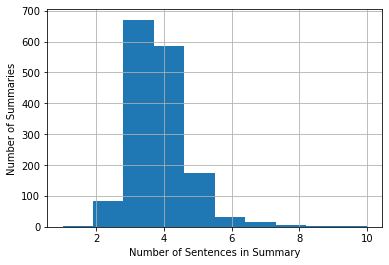

In [10]:
fig = bart_summaries.num_sent.hist()
plt.xlabel("Number of Sentences in Summary")
plt.ylabel("Number of Summaries")
plt.savefig(os.path.join(summarization_path,"bart_sent_lengths.png"))

In [0]:
bart_summaries.to_csv(os.path.join(summarization_path, "BART_summaries.csv"),index=False)

# Question Diversity

In [3]:
from collections import Counter, defaultdict

In [46]:
# results_folder = "/content/drive/My Drive/2020 Spring/NLU/Project/NLU_Project/SummQG/results"
results_folder = "../qgevalcap/cleaned_results"

data_file = os.path.join(results_folder, data_file_name)

In [79]:
def q_diversity(data_file):
    #n1 = Counter()
    n1_n2 = defaultdict(Counter)
    with open(data_file) as f:
        temp = ""
        for line in f:
            split_line = line.lower().split()
            if len(split_line)>2:
                n1_n2[split_line[0]][split_line[1]]+=1
            else:
                n1_n2[split_line[0]]['']+=1
            
    tables = []
    for k in n1_n2:
        temp = pd.DataFrame.from_dict(n1_n2[k],orient="index", columns=["instances"])
        temp.insert(0, "word_2",temp.index)
        temp.insert(0,"word_1",[k]*temp.shape[0])
        temp = temp.reset_index(drop=True)
        tables.append(temp)
    df = pd.concat(tables)
    df = df.reset_index(drop=True)
    return df, n1_n2


In [50]:
def stats(df):
    
    total = df.instances.sum()
    wh_words = df[df.word_1.isin(["who","what","when","where","what","why"])].instances.sum()
    others = total-wh_words
    top_5_w1_df = df.groupby("word_1").sum().sort_values("instances",ascending=False)
    top_5_w1_df["pct"] = top_5_w1_df["instances"]/total
    top_5_w1_w2_df = df.groupby(["word_1","word_2"]).sum().sort_values("instances",ascending=False)
    top_5_w1_w2_df["pct"] = top_5_w1_w2_df["instances"]/total
    
    print(f'Total: {total}')
    print(f'"WH" words: {wh_words} ... {wh_words/total}')
    print(f'others: {others} ... {others/total}')
    print('top 5 word 1')
    print(top_5_w1_df.head())
    print(top_5_w1_w2_df.head())
    
          
    
    return {"total": total, "wh_words": wh_words, "others": others}, top_5_w1_df, top_5_w1_w2_df

In [40]:
pd.set_option('display.max_rows', first_two_df.shape[0]+1) 

# Narrative QA

## Gold questions - nqa_gold.txt

In [80]:
data_file = os.path.join(results_folder, "nqa_gold.txt")
df_gold,_ = q_diversity(data_file)
stats_dict_gold, first_df_gold, first_two_df_gold = stats(df_gold)

Total: 8235
"WH" words: 6609 ... 0.8025500910746812
others: 1626 ... 0.19744990892531877
top 5 word 1
        instances       pct
word_1                     
what         3216  0.390528
who          1927  0.234001
how           845  0.102611
why           731  0.088767
where         607  0.073710
               instances       pct
word_1 word_2                     
what   is            792  0.096175
       does          689  0.083667
who    is            586  0.071160
       does          338  0.041044
why    does          291  0.035337


## Generated - nqa_generated.txt

In [82]:
data_file = os.path.join(results_folder, "nqa_generated.txt")
df_generated,_ = q_diversity(data_file)
stats_dict_generated, first_df_generated, first_two_df_generated = stats(df_generated)

Total: 8235
"WH" words: 7431 ... 0.902367941712204
others: 804 ... 0.09763205828779599
top 5 word 1
        instances       pct
word_1                     
what         3789  0.460109
who          2339  0.284032
how           761  0.092410
where         632  0.076746
why           610  0.074074
               instances       pct
word_1 word_2                     
who    is           1503  0.182514
what   does         1431  0.173770
       is           1121  0.136126
where  does          503  0.061081
who    does          479  0.058166
